Section 1: Import Data Set from google drive


*   V1 - Setup and load into dataframe called "df"
*   V2 - re-do the dataset to clean to 3 standard columns: subject, body, label. recast all labels to whole number integer.



In [ ]:
# This Colab script mounts your Google Drive and loads 'merged_dataset.csv'
# directly into a pandas DataFrame for model training or testing.

# Mount and read the new merged file directly from Drive by its real path.
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd

#file_path = '/content/drive/MyDrive/ENPM703 Group 7 Project/Merged Enron Dataset/merged_dataset.csv'  # <-- update to your exact path
file_path = '/content/drive/MyDrive/ENPM703_Fundamentals_of_AI_and_ML/Group_repo_award31/merged_dataset.csv'
#file_path = '/content/drive/Shared with me/ENPM703 Group 7 Project/Merged Enron Dataset/merged_dataset.csv'
assert os.path.exists(file_path), f"Not found: {file_path}"

df = pd.read_csv(file_path)

print("✅ Loaded:", file_path)
print("📋 Columns:", df.columns.tolist())
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# robust label count (handles 0,1 and 0.0,1.0)
label_counts = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int).value_counts().sort_index()
print("🔢 Label counts:\n", label_counts)

Mounted at /content/drive
✅ Loaded: /content/drive/MyDrive/ENPM703_Fundamentals_of_AI_and_ML/Group_repo_award31/merged_dataset.csv
📋 Columns: ['subject', 'body', 'label']
📊 Shape: 145639 rows × 3 columns
🔢 Label counts:
 label
0    68452
1    77187
Name: count, dtype: int64


Section 2: Data Summary
this section is for summarizing key statistic and information about the data for easy reference.

revision:


*   V1 setup: number of rows, number of columns and headers, number of 0 and 1 labels representting proportion of OK and NG emails respectively
*   V2 - cleaned up to display the updated and cleaned merged_dataset



In [ ]:
# Print column headers and count total 0s and 1s in the 'label' column

# Column headers
print("📋 Column Headers:")
print(df.columns.tolist())
print("\n")

# Convert the label column safely to integers (handles 0.0/1.0 etc.)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

# Count and sum
label_counts = df['label'].value_counts().sort_index()
total_zeros = label_counts.get(0, 0)
total_ones = label_counts.get(1, 0)

print("🔢 Label Counts:")
print(f"0 (OK emails): {total_zeros}")
print(f"1 (Phishing emails): {total_ones}")
print(f"📊 Total emails: {total_zeros + total_ones}")

📋 Column Headers:
['subject', 'body', 'label']


🔢 Label Counts:
0 (OK emails): 68452
1 (Phishing emails): 77187
📊 Total emails: 145639


Section 3: Data Preprocessing
Purpose: divy up data into train, validate, and test data sub sets

Revision:
V1 - new code

In [ ]:

from sklearn.model_selection import train_test_split

# set a random seed for repeatability
RANDOM_SEED = 42

# ensure labels are integers
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

# split data: 70% train, 30% temp
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])

# split temp into 20% validation and 10% test (relative to full dataset)
val_df, test_df = train_test_split(temp_df, test_size=(1/3), random_state=RANDOM_SEED, stratify=temp_df['label'])

# print summaries
print("Training set size:", len(train_df))
print(train_df['label'].value_counts().sort_index(), "\n")

print("Validation set size:", len(val_df))
print(val_df['label'].value_counts().sort_index(), "\n")

print("Testing set size:", len(test_df))
print(test_df['label'].value_counts().sort_index())

print("Total set size:", len(train_df) + len(val_df) + len(test_df))

Training set size: 101947
label
0    47916
1    54031
Name: count, dtype: int64 

Validation set size: 29128
label
0    13691
1    15437
Name: count, dtype: int64 

Testing set size: 14564
label
0    6845
1    7719
Name: count, dtype: int64
Total set size: 145639


Section 4: Literature Model Replication
Purpose: this section reproduces some results form literature to familiarize with existing methods and their strengths and weaknesses

Target Models:
List of Models and Reference Papers

	1.	BiLSTM (subject) + LSTM (body) + XGBoost with custom loss - He et al. (2024) — Double-layer architecture for phishing and insider threat detection

	2.	Improved RCNN (CNN + BiLSTM) with attention mechanism - Fang et al. (2019) — Character and word-level phishing detection using hybrid deep learning

	3.	Deep Feed-Forward Neural Network (FFNN) - Kaddoura et al. (2020) — Comparison of FFNN vs. BERT for phishing detection

	4.	LSTM-GRU Hybrid for multi-class email classification (SeFACED) - Hina et al. (2021) — Semantic forensic analysis of emails using deep learning

	5.	Hybrid BiLSTM + Deep Neural Network (DNN) - Krishnamoorthy et al. (2024) — Hybrid model for phishing detection and emotion-aware email classification

Revision:
V1 - new code

Dataset Setup (Text → Tensor).
Prepares text → token → tensor pipeline and DataLoaders.

In [ ]:
# ==============================================
# 1. Import required libraries
# ==============================================
import re, random, torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import os

# ==============================================
# 2. Combine the subject and body text columns
#    into one unified text field for simplicity.
# ==============================================
def normalize(s):
    # Clean extra whitespace and handle None values
    return re.sub(r"\s+", " ", str(s or "")).strip()

for part in ("train_df", "val_df", "test_df"):
    d = globals()[part]
    # Create a single "text" column combining subject and body
    d["text"] = (d["subject"].map(normalize) + " " + d["body"].map(normalize)).str.strip()

# ==============================================
# 3. Simple whitespace tokenizer
#    (split text into lowercase tokens)
# ==============================================
def tokenize(s):
    return s.lower().split()

# ==============================================
# 4. Build a vocabulary (word → integer ID)
#    using only the training texts
# ==============================================
PAD, UNK = "<pad>", "<unk>"

def build_vocab(texts, min_freq=2, max_size=30000):
    counter = Counter()
    # Count token frequency across all training texts
    for t in texts:
        counter.update(tokenize(t))
    # Keep most common tokens within max size
    itos = [PAD, UNK] + [w for w, c in counter.most_common() if c >= min_freq][:max_size-2]
    stoi = {w: i for i, w in enumerate(itos)}
    return stoi, itos

stoi, itos = build_vocab(train_df["text"].tolist(), min_freq=2, max_size=30000)
pad_id, unk_id = stoi[PAD], stoi[UNK]

# ==============================================
# 5. Convert each text into a fixed-length tensor
#    of token IDs, padded or truncated as needed
# ==============================================
def encode(text, max_len=256):
    ids = [stoi.get(tok, unk_id) for tok in tokenize(text)]
    ids = ids[:max_len]                               # Truncate long texts
    length = len(ids)
    if length < max_len:
        ids = ids + [pad_id] * (max_len - length)     # Pad short texts
    return torch.tensor(ids, dtype=torch.long), torch.tensor(length, dtype=torch.long)

# ==============================================
# 6. Define a PyTorch Dataset class
#    (returns padded tensor, sequence length, and label)
# ==============================================
class TextDataset(Dataset):
    def __init__(self, df, max_len=256):
        texts = df["text"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.max_len = max_len
        # Precompute tensors ONCE
        xs, Ls = [], []
        for t in texts:
            x, L = encode(t, max_len)
            xs.append(x)
            Ls.append(L)
        self.xs = torch.stack(xs)      # [N, T]
        self.Ls = torch.stack(Ls)      # [N]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        #x, L = encode(self.labels[i], self.max_len)
        y = torch.tensor(self.labels[i], dtype=torch.long)
        return self.xs[i], self.Ls[i], y

# Create dataset objects for train/validation/test
train_ds = TextDataset(train_df, max_len=256)
val_ds   = TextDataset(val_df,   max_len=256)
test_ds  = TextDataset(test_df,  max_len=256)

# ==============================================
# 7. Collate function for DataLoader
#    (stacks samples into batches)
# ==============================================
def collate(batch):
    xs, Ls, ys = zip(*batch)
    return torch.stack(xs), torch.stack(Ls), torch.stack(ys)

# ==============================================
# 8. Create DataLoaders for batching
# ==============================================

cuda = torch.cuda.is_available()

# Use at most 2 workers on Colab (per warning)
max_recommended = 2
cpu_count = os.cpu_count() or 2
num_workers = min(max_recommended, max(1, cpu_count // (2 if not cuda else 1)))

# Pin memory only for CUDA; persistent_workers only valid if num_workers > 0
pin_memory = cuda
persistent = (num_workers > 0)

common_dl_kwargs = dict(
    collate_fn=collate,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent
)

# prefetch_factor is only valid when num_workers > 0
if num_workers > 0:
    common_dl_kwargs["prefetch_factor"] = 2

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  **common_dl_kwargs)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, **common_dl_kwargs)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, **common_dl_kwargs)

# Confirm settings in output
print(f"cuda={cuda} | num_workers={num_workers} | pin_memory={pin_memory} | persistent_workers={persistent}")

# Store vocabulary size for model input dimension
vocab_size = len(itos)


cuda=True | num_workers=2 | pin_memory=True | persistent_workers=True


BiLSTM + DNN Model Definition. Builds the BiLSTM + DNN classifier ready for training.

In [ ]:
# ==============================================
# 1. Import PyTorch neural-network module
# ==============================================
import torch.nn as nn

# ==============================================
# 2. Define BiLSTM + DNN hybrid model
#    - Embedding layer turns token IDs → vectors
#    - BiLSTM learns bidirectional text context
#    - DNN head classifies output into labels
# ==============================================
class BiLSTM_DNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden=128, mlp=64, num_classes=2, pad_idx=0):
        super().__init__()

        # --- Embedding layer: converts token IDs to dense vectors ---
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        # --- Bidirectional LSTM: captures context both ways ---
        self.lstm = nn.LSTM(emb_dim, hidden, batch_first=True, bidirectional=True)

        # --- Deep Neural Network (fully connected layers) ---
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden, mlp),   # Combine both directions of LSTM
            nn.ReLU(),                    # Nonlinear activation
            nn.Dropout(0.2),              # Regularization to prevent overfitting
            nn.Linear(mlp, num_classes)   # Output logits for each class
        )

    def forward(self, x, lengths):
        # x: [batch_size, seq_len]
        # lengths: [batch_size]

        # --- Step 1: Look up embeddings ---
        emb = self.emb(x)  # [B, T, E]

        # --- Step 2: Pack padded sequences (for efficiency) ---
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # --- Step 3: Pass through BiLSTM ---
        out_packed, (h, c) = self.lstm(packed)

        # --- Step 4: Concatenate the final hidden states from both directions ---
        h_final = torch.cat([h[0], h[1]], dim=1)  # [B, 2H]

        # --- Step 5: Pass through DNN head to produce logits ---
        return self.fc(h_final)

# ==============================================
# 3. Instantiate model with your vocabulary size
# ==============================================
model = BiLSTM_DNN(
    vocab_size=vocab_size,
    emb_dim=100,
    hidden=128,
    mlp=64,
    num_classes=2,
    pad_idx=pad_id
)


Training + Validation (with early stopping, AMP, LR scheduler)

In [ ]:
# ==============================================
# 0) Housekeeping: device, seeds, and helpers
# ==============================================
import math, time, os, random, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torch import amp

# --- Pick device (GPU if available) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Set seeds for reproducibility ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

# --- Move model to the device ---
model = model.to(device)

# ==============================================
# 1) Loss function, optimizer, scheduler
#    - CrossEntropy for multi-class (binary included)
#    - AdamW is stable and commonly used
#    - ReduceLROnPlateau lowers LR on stalled val loss
# ==============================================
criterion = nn.CrossEntropyLoss()           # If classes are imbalanced, pass weight=class_weights
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

# ==============================================
# 2) Mixed precision (speeds up training on GPU)
#    - Safe default: enable if CUDA available
# ==============================================
USE_AMP = torch.cuda.is_available()
scaler = amp.GradScaler('cuda', enabled=USE_AMP)

# ==============================================
# 3) Metric helpers (accuracy, precision, recall, F1)
#    - All computed on CPU-friendly tensors at the end of an epoch
# ==============================================
def compute_metrics(y_true, y_pred):
    """
    y_true: 1D tensor/list of ints (gold labels)
    y_pred: 1D tensor/list of ints (predicted labels)
    """
    y_true = torch.as_tensor(y_true)
    y_pred = torch.as_tensor(y_pred)
    correct = (y_true == y_pred).sum().item()
    total = len(y_true)
    acc = correct / max(total, 1)

    # Binary or multi-class: compute macro-averaged Precision/Recall/F1
    num_classes = int(max(y_true.max().item(), y_pred.max().item())) + 1
    precision_vals, recall_vals, f1_vals = [], [], []
    for cls in range(num_classes):
        tp = ((y_pred == cls) & (y_true == cls)).sum().item()
        fp = ((y_pred == cls) & (y_true != cls)).sum().item()
        fn = ((y_pred != cls) & (y_true == cls)).sum().item()
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = 2*prec*rec / (prec + rec) if (prec + rec) > 0 else 0.0
        precision_vals.append(prec); recall_vals.append(rec); f1_vals.append(f1)
    precision = float(np.mean(precision_vals))
    recall    = float(np.mean(recall_vals))
    f1        = float(np.mean(f1_vals))
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ==============================================
# 4) One epoch of training
#    - Loops over train_loader, updates weights
#    - Tracks running loss
# ==============================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    n_examples = 0

    for x, lengths, y in loader:
        # --- Move batch to device ---
        x = x.to(device)
        lengths = lengths.to(device)
        y = y.to(device)

        # --- Reset gradients ---
        optimizer.zero_grad(set_to_none=True)

        # --- Forward pass (with AMP if enabled) ---
        with amp.autocast('cuda', enabled=USE_AMP):
            logits = model(x, lengths)          # [B, num_classes]
            loss = criterion(logits, y)

        # --- Backward + step (with AMP scaler) ---
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # --- Track loss ---
        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        n_examples += batch_size

    return running_loss / max(n_examples, 1)

# ==============================================
# 5) One epoch of validation
#    - No grad; collects predictions for metrics
# ==============================================
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    n_examples = 0
    all_gold, all_pred = [], []

    with torch.no_grad():
        for x, lengths, y in loader:
            x = x.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            with amp.autocast('cuda', enabled=USE_AMP):
                logits = model(x, lengths)
                loss = criterion(logits, y)

            batch_size = x.size(0)
            running_loss += loss.item() * batch_size
            n_examples += batch_size

            preds = torch.argmax(logits, dim=1)
            all_gold.extend(y.detach().cpu().tolist())
            all_pred.extend(preds.detach().cpu().tolist())

    avg_loss = running_loss / max(n_examples, 1)
    metrics = compute_metrics(all_gold, all_pred)
    return avg_loss, metrics

# ==============================================
# 6) Full training loop
#    - Early stopping on best val loss
#    - LR scheduler on plateau
#    - Saves best checkpoint
# ==============================================
def fit(model, train_loader, val_loader, epochs=10, patience=3, ckpt_path="/content/drive/MyDrive/newrev/bilstm_dnn_best.pt"):
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(1, epochs + 1):
        t0 = time.time()
        # --- Train for one epoch ---
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)

        # --- Evaluate on validation set ---
        val_loss, val_metrics = evaluate(model, val_loader, criterion)

        # --- Record history ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_metrics["accuracy"])
        history["val_f1"].append(val_metrics["f1"])

        # --- Step LR scheduler based on validation loss ---
        scheduler.step(val_loss)

        # Show the new learning rate
        for pg in optimizer.param_groups:
            print(f"Current LR: {pg['lr']:.6f}")

        # --- Check for improvement (early stopping) ---
        improved = val_loss < best_val_loss - 1e-6
        if improved:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            torch.save(best_state, ckpt_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # --- Progress printout for quick inspection ---
        dt = time.time() - t0
        print(f"[Epoch {epoch:02d}] "
              f"train_loss={train_loss:.4f} | "
              f"val_loss={val_loss:.4f} | "
              f"val_acc={val_metrics['accuracy']:.4f} | "
              f"val_f1={val_metrics['f1']:.4f} | "
              f"time={dt:.1f}s | "
              f"{'*' if improved else ''}")

        # --- Early stop when patience exceeded ---
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch} epochs (no improvement for {patience} checks).")
            break

    # --- Load best weights back into the model ---
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# # ==============================================
# # 7) (Optional) Tiny sanity check: can the model
# #    overfit a single small batch? Uncomment to try
# #    and comment out history line, swap back when good.
# # ==============================================

# # Save BEFORE the overfit test
# init_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# #... run overfit block (optional)...

# model_small = model
# x_small, L_small, y_small = next(iter(train_loader))
# x_small, L_small, y_small = x_small[:64].to(device), L_small[:64].to(device), y_small[:64].to(device)
# optimizer_small = optim.AdamW(model_small.parameters(), lr=5e-3)
# for i in range(200):
#     optimizer_small.zero_grad(set_to_none=True)
#     with amp.autocast('cuda', enabled=USE_AMP):
#         logits = model_small(x_small, L_small)
#         loss = criterion(logits, y_small)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer_small)
#     scaler.update()
#     if (i+1) % 25 == 0:
#         pred = logits.argmax(1)
#         acc = (pred == y_small).float().mean().item()
#         print(f"overfit step {i+1:03d}: loss={loss.item():.4f}, acc={acc:.3f}")

# ==============================================
# 8) Train for real
# ==============================================

# Restore BEFORE calling fit(...)       #(optional)
# model.load_state_dict(init_state)

################################### Real Model Training starts below here if no sanity check
RUN_TRAINING = True  # 🔴 make/keep False then it won't retrain only change if really want to retrain

if RUN_TRAINING:
    # --- Start total training timer ---
    start_time = time.time()

    history = fit(model, train_loader, val_loader, epochs=12, patience=3, ckpt_path="/content/drive/MyDrive/newrev/bilstm_dnn_best.pt")

    # --- End total training timer ---
    total_time = time.time() - start_time
    hrs, rem = divmod(total_time, 3600)
    mins, secs = divmod(rem, 60)
    print(f"\nTotal training time: {int(hrs)}h {int(mins)}m {secs:.1f}s")

Current LR: 0.002000
[Epoch 01] train_loss=0.1263 | val_loss=0.1363 | val_acc=0.9495 | val_f1=0.9490 | time=25.7s | *
Current LR: 0.002000
[Epoch 02] train_loss=0.0391 | val_loss=0.0446 | val_acc=0.9854 | val_f1=0.9853 | time=23.5s | *
Current LR: 0.002000
[Epoch 03] train_loss=0.0188 | val_loss=0.0441 | val_acc=0.9870 | val_f1=0.9869 | time=22.9s | *
Current LR: 0.002000
[Epoch 04] train_loss=0.0064 | val_loss=0.0491 | val_acc=0.9877 | val_f1=0.9876 | time=23.3s | 
Current LR: 0.001000
[Epoch 05] train_loss=0.0046 | val_loss=0.0616 | val_acc=0.9877 | val_f1=0.9877 | time=23.4s | 
Current LR: 0.001000
[Epoch 06] train_loss=0.0017 | val_loss=0.0655 | val_acc=0.9879 | val_f1=0.9879 | time=23.3s | 
Early stopping after 6 epochs (no improvement for 3 checks).

Total training time: 0h 2m 22.2s


**Temporary checkpoint save (use when training stops on its own)**

In [ ]:
import torch
torch.save(model.state_dict(), "/content/drive/MyDrive/newrev/bilstm_dnn_temp_stop.pt")
print("✅ Temporary checkpoint saved.")

✅ Temporary checkpoint saved.


**Resume-training cell (use if need/want to resume training) (optional)**

In [ ]:
# ==============================================
# 8b) Resume training from existing checkpoint
#      (instead of starting from scratch)
# ==============================================
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch import amp

# Make sure device and seed are consistent with earlier cells
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Recreates the SAME model architecture as before
model = BiLSTM_DNN(
    vocab_size=vocab_size,
    emb_dim=100,
    hidden=128,
    mlp=64,
    num_classes=2,
    pad_idx=pad_id
).to(device)

# Path to existing best checkpoint
ckpt_path = "/content/drive/MyDrive/newrev/bilstm_dnn_best.pt"

# Load weights into the model (if file exists)
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("✅ Loaded existing checkpoint from", ckpt_path)
else:
    print("⚠️ Warning: checkpoint not found at", ckpt_path, "- training will start from fresh init.")

# Re-create optimizer / scheduler / loss / scaler for this run
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)
USE_AMP    = torch.cuda.is_available()
scaler     = amp.GradScaler('cuda', enabled=USE_AMP)

# IMPORTANT: fit() uses the global criterion/optimizer/scheduler/scaler defined above,
# so set them here *before* calling fit.

# Optional: start a fresh history object for this "resume" run
# (this will only contain the extra epochs you train now)
extra_epochs     = 5     # change if you want more/less
extra_patience   = 2     # early stopping patience for this resume run

print(f"\n▶️ Resuming training for {extra_epochs} more epochs...")
history_more = fit(
    model,
    train_loader,
    val_loader,
    epochs=extra_epochs,
    patience=extra_patience,
    ckpt_path=ckpt_path     # overwrites if gets a better model
)

print("\n✅ Resume training complete. Best model updated at:", ckpt_path)


Confusion matrix (compute + plot)

In [ ]:
# ==============================================
# 9) Confusion matrix helpers (define once)
# ==============================================
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- Collect predictions and gold labels over a DataLoader ---
def collect_preds(model, loader, device):
    model.eval()
    all_gold, all_pred = [], []
    with torch.no_grad():
        for x, lengths, y in loader:
            x = x.to(device)
            lengths = lengths.to(device)
            # y can stay on CPU; so it's only appended
            logits = model(x, lengths)
            preds = torch.argmax(logits, dim=1)

            all_gold.extend(y.tolist())
            all_pred.extend(preds.cpu().tolist())
    return np.array(all_gold), np.array(all_pred)

# --- Build confusion matrix (C x C) ---
def confusion_matrix(y_true, y_pred, num_classes=None):
    if num_classes is None:
        num_classes = int(max(y_true.max(), y_pred.max())) + 1
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

# --- Plot confusion matrix (counts or normalized) ---
def plot_confusion_matrix(cm, class_names=None, normalize=False, title="Confusion Matrix"):
    # Optionally normalize rows to sum to 1
    cm_display = cm.astype(np.float64)
    if normalize:
        row_sums = cm_display.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_display = cm_display / row_sums

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_display, interpolation="nearest")  # default colormap

    # Title and axes
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Ticks
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add numbers inside the cells
    thresh = cm_display.max() / 2.0 if cm_display.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize:
                text_val = cm_display[i, j]   # float, show as 0.xx
                fmt = ".2f"
            else:
                text_val = cm[i, j]          # integer count
                fmt = "d"
            ax.text(j, i, format(text_val, fmt),
                    ha="center", va="center",
                    color="white" if cm_display[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()
    return fig



Final Test Evaluation (load best ckpt, compute metrics)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded trained weights from /content/drive/MyDrive/newrev/bilstm_dnn_best.pt
[TEST] loss=0.0500 | acc=0.9843 | precision=0.9843 | recall=0.9843 | f1=0.9843


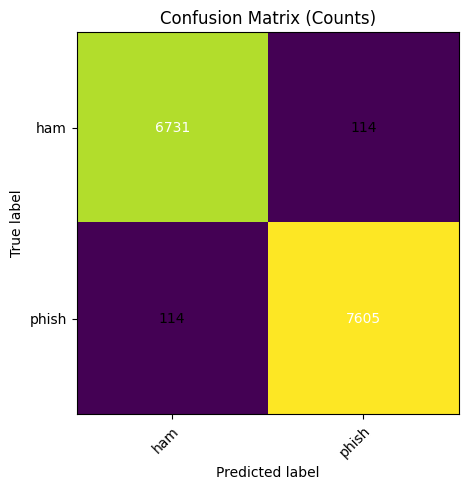

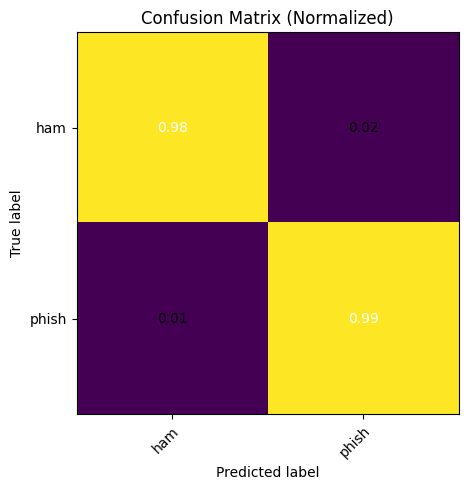

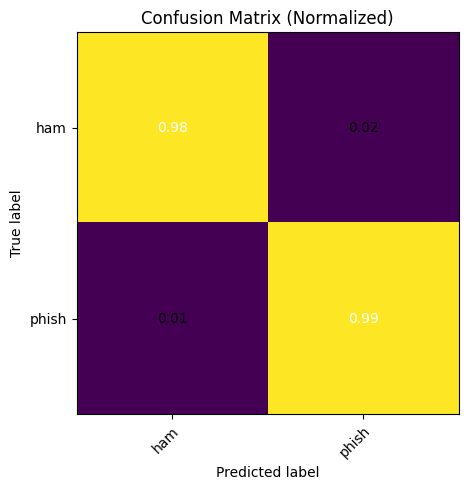

In [ ]:
# ==============================================
# 9b) Load the best checkpoint and evaluate on TEST
# ==============================================
from google.colab import drive
drive.mount('/content/drive')

# just in case not imported above
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create model with same architecture (already created above as `model`)
model = BiLSTM_DNN(
    vocab_size=vocab_size,
    emb_dim=100,
    hidden=128,
    mlp=64,
    num_classes=2,
    pad_idx=pad_id
).to(device)

# --- best ckpt loads below here ---
# Path to saved checkpoint
ckpt_path = "/content/drive/MyDrive/newrev/bilstm_dnn_best.pt"

# Load weights
if os.path.exists(ckpt_path):
    # state = torch.load(ckpt_path, map_location="cpu")
    # model.load_state_dict(state)
    # model = model.to(device)
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    print("✅ Loaded trained weights from", ckpt_path)
else:
    print("Warning: best checkpoint not found; using current model weights.")

# Reuse criterion from above (or recreate if needed)
criterion = nn.CrossEntropyLoss()

test_loss, test_metrics = evaluate(model, test_loader, criterion)
print(f"[TEST] loss={test_loss:.4f} | "
      f"acc={test_metrics['accuracy']:.4f} | "
      f"precision={test_metrics['precision']:.4f} | "
      f"recall={test_metrics['recall']:.4f} | "
      f"f1={test_metrics['f1']:.4f}")

# ==============================================
# 9c) Confusion Matrix on Test Set
# ==============================================
# Make sure to run the confusion-matrix helper functions are defined
# (they may appear later in the notebook — if not ran, run that cell first)

y_true, y_pred = collect_preds(model, test_loader, device)
cm = confusion_matrix(y_true, y_pred, num_classes=2)

# Plot both count and normalized confusion matrices
plot_confusion_matrix(cm, class_names=["ham", "phish"],
                      normalize=False, title="Confusion Matrix (Counts)")

plot_confusion_matrix(cm, class_names=["ham", "phish"],
                      normalize=True, title="Confusion Matrix (Normalized)")


Separate Dataset Processing + Blind Inference + CSV Exports + Class Distribution & Row Count Plots

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded: /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_KD_10000.csv
📋 Columns: ['text', 'label', 'phishing_type', 'severity', 'confidence']
📊 Shape: (10000, 5)

🔢 Label counts after alignment:
label
0    4000
1    6000
Name: count, dtype: int64

💾 Saved aligned dataset (training format): /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_aligned.csv
💾 Saved blind dataset (no labels): /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_blind.csv
🧾 Training dataset (merged_dataset.csv)
----------------------------------------
Columns: ['subject', 'body', 'label']
Shape  : (145639, 3)

Label counts (train):
label
0    68452
1    77187
Name: count, dtype: int64

Sample rows (train):


,subject,body,label
0,"FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0
1,NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0
2,RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0




🧾 Separate test dataset (phishing_legit_dataset_KD_10000_aligned)
----------------------------------------------------------------
Columns: ['body', 'label', 'phishing_type', 'severity', 'confidence', 'subject', 'text']
Shape  : (10000, 7)

Label counts (separate aligned):
label
0    4000
1    6000
Name: count, dtype: int64

Sample rows (separate aligned):


,subject,body,label
0,,Subject: Office maintenance\n\nThanks for your...,0
1,,"Hello, your profile has been locked. Use the s...",1
2,,"Hi there, congratulations! You are the winner ...",1



📋 Schema & consistency checks:
• Train has columns       : {'subject', 'label', 'body'}
• Separate aligned has    : {'confidence', 'severity', 'body', 'phishing_type', 'subject', 'label', 'text'}
• Core columns present in BOTH (subject, body, label): ✅ YES

🧪 dtypes (train):
subject    object
body       object
label       int64
dtype: object

🧪 dtypes (separate aligned):
subject    object
body       object
label       int64
dtype: object

📊 Empty-field percentages:
Train  empty 'subject':    0.00%
Separate empty 'subject':100.00%
Train  empty 'body':       0.00%
Separate empty 'body':     0.00%

✅ PASS: Separate test dataset is aligned with the training dataset (same core columns and integer labels).

[BLIND INFERENCE RESULTS – Separate Dataset]
Accuracy:  0.9745
Precision: 0.9925
Recall:    0.9648
F1 Score:  0.9785


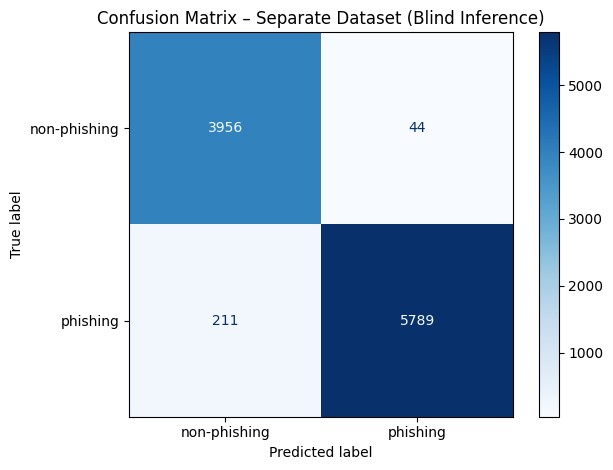

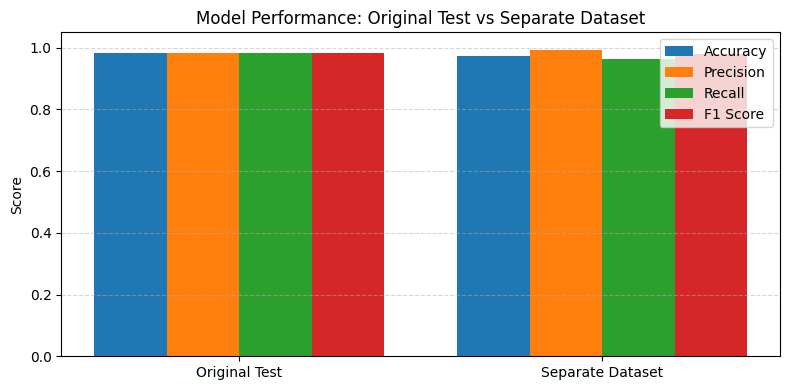


💾 Saved final classified dataset with predictions: /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_with_predictions.csv
   Columns: subject, body, label, text, pred, pred_class, true_class

📊 Plotting class distributions and row counts...


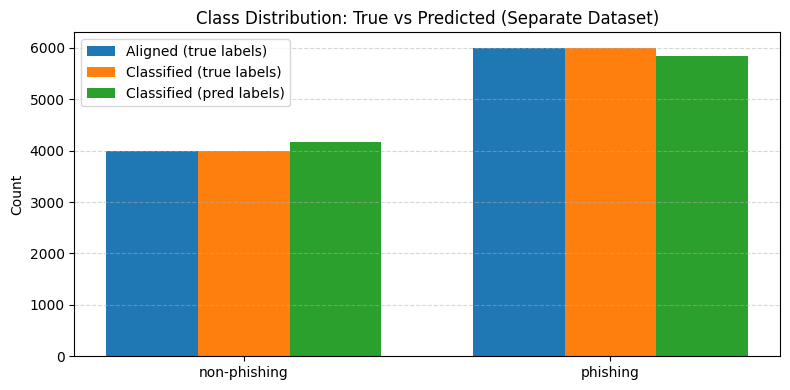

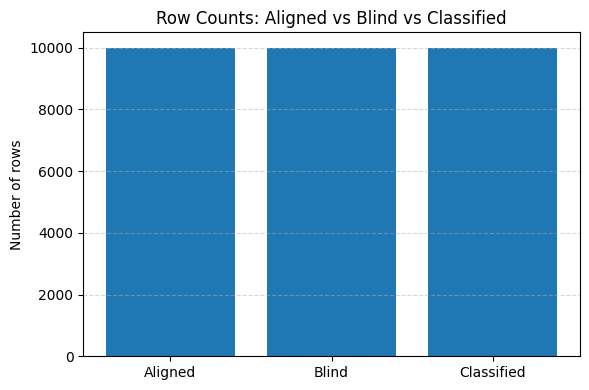


✅ All outputs complete!
- Aligned dataset:    /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_aligned.csv
- Blind dataset:      /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_blind.csv
- Classified results: /content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_with_predictions.csv


In [ ]:
# ============================================================
# Separate Dataset Processing + Blind Inference + CSV Exports
# + Class Distribution & Row Count Plots
# ============================================================
import os, pandas as pd, numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# === 1. Define paths (EDIT these as needed) ===
input_csv_path  = "/content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_KD_10000.csv"
aligned_csv_out = "/content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_aligned.csv"
blind_csv_out   = "/content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_blind.csv"
results_csv_out = "/content/drive/MyDrive/newrev/newrev_bilstm_csv/phishing_legit_dataset_with_predictions.csv"

assert os.path.exists(input_csv_path), f"❌ File not found: {input_csv_path}"

# === 2. Load the separate dataset ===
df_new = pd.read_csv(input_csv_path)
print("✅ Loaded:", input_csv_path)
print("📋 Columns:", df_new.columns.tolist())
print("📊 Shape:", df_new.shape)

# === 3. Align column names to match training (subject, body, label) ===
col_map = {}
if "subject" in df_new.columns and "body" in df_new.columns:
    col_map = {}
elif {"Email_Subject", "Email_Body"}.issubset(df_new.columns):
    col_map = {"Email_Subject": "subject", "Email_Body": "body"}
elif "text" in df_new.columns and "subject" not in df_new.columns:
    df_new["subject"] = ""
    col_map = {"text": "body"}

if col_map:
    df_new = df_new.rename(columns=col_map)

required_cols = {"subject", "body", "label"}
missing = required_cols - set(df_new.columns)
if missing:
    raise ValueError(f"Missing required columns in df_new: {missing}")

# === 4. Clean and combine text columns ===
df_new["label"] = pd.to_numeric(df_new["label"], errors="coerce").fillna(0).astype(int)

def normalize(s):
    return re.sub(r"\s+", " ", str(s or "")).strip()

df_new["text"] = df_new["subject"].map(normalize) + " " + df_new["body"].map(normalize)
df_new["text"] = df_new["text"].str.strip()

print("\n🔢 Label counts after alignment:")
print(df_new["label"].value_counts().sort_index())

# === 5. Save aligned version (training-compatible) ===
df_new.to_csv(aligned_csv_out, index=False)
print(f"\n💾 Saved aligned dataset (training format): {aligned_csv_out}")

# === 6. Create blind (no labels) copy ===
df_blind = df_new.drop(columns=["label"])
df_blind.to_csv(blind_csv_out, index=False)
print(f"💾 Saved blind dataset (no labels): {blind_csv_out}")


# ------- comparison cell ---------

# ============================================================
# BEFORE vs AFTER COMPARISON
#   - TRAINING merged_dataset (df)
#   - SEPARATE TEST (df_new, after alignment)
#   - Read-only: does NOT modify any data
# ============================================================

print("🧾 Training dataset (merged_dataset.csv)")
print("----------------------------------------")
print("Columns:", df.columns.tolist())
print("Shape  :", df.shape)
print("\nLabel counts (train):")
print(df["label"].value_counts().sort_index())

print("\nSample rows (train):")
display(df[["subject", "body", "label"]].head(3))


print("\n\n🧾 Separate test dataset (phishing_legit_dataset_KD_10000_aligned)")
print("----------------------------------------------------------------")
print("Columns:", df_new.columns.tolist())
print("Shape  :", df_new.shape)
print("\nLabel counts (separate aligned):")
print(df_new["label"].value_counts().sort_index())

print("\nSample rows (separate aligned):")
display(df_new[["subject", "body", "label"]].head(3))


# ---- Schema & basic consistency checks ----
print("\n📋 Schema & consistency checks:")

train_cols = set(df.columns)
sep_cols   = set(df_new.columns)

print("• Train has columns       :", train_cols)
print("• Separate aligned has    :", sep_cols)

core_cols = {"subject", "body", "label"}
core_ok = core_cols.issubset(train_cols) and core_cols.issubset(sep_cols)
print(f"• Core columns present in BOTH (subject, body, label): {'✅ YES' if core_ok else '❌ NO'}")

# Check dtypes for key columns
print("\n🧪 dtypes (train):")
print(df[["subject", "body", "label"]].dtypes)
print("\n🧪 dtypes (separate aligned):")
print(df_new[["subject", "body", "label"]].dtypes)

# Check emptiness ratios
def empty_pct(series):
    return (series.astype(str).str.strip() == "").mean() * 100

print("\n📊 Empty-field percentages:")
print(f"Train  empty 'subject':  {empty_pct(df['subject']):6.2f}%")
print(f"Separate empty 'subject':{empty_pct(df_new['subject']):6.2f}%")
print(f"Train  empty 'body':     {empty_pct(df['body']):6.2f}%")
print(f"Separate empty 'body':   {empty_pct(df_new['body']):6.2f}%")

# Final PAS / WARN message
if core_ok:
    print("\n✅ PASS: Separate test dataset is aligned with the training dataset "
          "(same core columns and integer labels).")
else:
    print("\n⚠️ WARNING: Separate test dataset is missing one or more core columns "
          "(subject, body, label) – fix before inference.")

# ------- end comparison cell ---------


# === 7. Run blind inference using the trained model ===
model.eval()
preds = []
with torch.no_grad():
    for text in df_blind["text"]:
        ids, L = encode(text, max_len=256)
        ids = ids.unsqueeze(0).to(device)
        L   = L.unsqueeze(0).to(device)
        logits = model(ids, L)
        y_pred = logits.argmax(dim=1).item()
        preds.append(y_pred)

df_pred = df_blind.copy()
df_pred["pred"] = preds

# === 8. Merge predictions with original labels for evaluation ===
df_eval = df_new.copy()
df_eval["pred"] = preds
df_eval["pred_class"] = df_eval["pred"].map({0: "non-phishing", 1: "phishing"})
df_eval["true_class"] = df_eval["label"].map({0: "non-phishing", 1: "phishing"})

# === 9. Compute metrics ===
acc_new  = accuracy_score(df_eval["label"], df_eval["pred"])
prec_new = precision_score(df_eval["label"], df_eval["pred"])
rec_new  = recall_score(df_eval["label"], df_eval["pred"])
f1_new   = f1_score(df_eval["label"], df_eval["pred"])

print(f"\n[BLIND INFERENCE RESULTS – Separate Dataset]")
print(f"Accuracy:  {acc_new:.4f}")
print(f"Precision: {prec_new:.4f}")
print(f"Recall:    {rec_new:.4f}")
print(f"F1 Score:  {f1_new:.4f}")

# === 10. Confusion matrix for the separate dataset ===
cm_new = confusion_matrix(df_eval["label"], df_eval["pred"])
disp = ConfusionMatrixDisplay(cm_new, display_labels=["non-phishing", "phishing"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Separate Dataset (Blind Inference)")
plt.tight_layout()
plt.show()

# === 11. Compare vs original test set ===
criterion_tmp = nn.CrossEntropyLoss()
orig_test_loss, orig_test_metrics = evaluate(model, test_loader, criterion_tmp)

labels_sets = ["Original Test", "Separate Dataset"]
acc_vals  = [orig_test_metrics["accuracy"],  acc_new]
f1_vals   = [orig_test_metrics["f1"],        f1_new]
prec_vals = [orig_test_metrics["precision"], prec_new]
rec_vals  = [orig_test_metrics["recall"],    rec_new]

x = np.arange(len(labels_sets))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - 1.5*width, acc_vals,  width, label="Accuracy")
ax.bar(x - 0.5*width, prec_vals, width, label="Precision")
ax.bar(x + 0.5*width, rec_vals,  width, label="Recall")
ax.bar(x + 1.5*width, f1_vals,   width, label="F1 Score")

ax.set_xticks(x)
ax.set_xticklabels(labels_sets)
ax.set_ylim(0.0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Model Performance: Original Test vs Separate Dataset")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# === 12. Save classified results CSV ===
df_eval.to_csv(results_csv_out, index=False)
print(f"\n💾 Saved final classified dataset with predictions: {results_csv_out}")
print("   Columns: subject, body, label, text, pred, pred_class, true_class")

# === 13. Sanity plots: class distribution & row counts ===
print("\n📊 Plotting class distributions and row counts...")

# Class distributions: true (aligned), true (classified), pred (classified)
class_names = ["non-phishing", "phishing"]

# Ensure to always have counts in order [0,1]
def counts_for(series):
    vc = series.value_counts().sort_index()
    return [vc.get(0, 0), vc.get(1, 0)]

aligned_counts_true   = counts_for(df_new["label"])
classified_counts_true = counts_for(df_eval["label"])
classified_counts_pred = counts_for(df_eval["pred"])

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width,     aligned_counts_true,    width, label="Aligned (true labels)")
ax.bar(x,             classified_counts_true, width, label="Classified (true labels)")
ax.bar(x + width,     classified_counts_pred, width, label="Classified (pred labels)")

ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylabel("Count")
ax.set_title("Class Distribution: True vs Predicted (Separate Dataset)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Row counts: aligned vs blind vs classified
row_counts_labels = ["Aligned", "Blind", "Classified"]
row_counts_vals   = [len(df_new), len(df_blind), len(df_eval)]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(len(row_counts_labels)), row_counts_vals)
ax.set_xticks(np.arange(len(row_counts_labels)))
ax.set_xticklabels(row_counts_labels)
ax.set_ylabel("Number of rows")
ax.set_title("Row Counts: Aligned vs Blind vs Classified")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

print("\n✅ All outputs complete!")
print(f"- Aligned dataset:    {aligned_csv_out}")
print(f"- Blind dataset:      {blind_csv_out}")
print(f"- Classified results: {results_csv_out}")


Emotion helpers (tokenizer + lexicon + vector builder)

In [ ]:
# ==============================================
# 11) Emotion analysis helpers (Option 1 - no retrain)
#     - Simple tokenizer for emotion analysis
#     - Tiny example emotion lexicon
#     - Function to build an emotion vector
# ==============================================
import re
import numpy as np

# Very simple tokenizer for emotion analysis (independent of model tokenizer)
EMO_WORD_RE = re.compile(r"[a-zA-Z]+")

def emo_tokenize(text):
    """
    Lowercase and pull alphabetic tokens.
    This is separate from the model's tokenize() and can be swapped later.
    """
    text = str(text or "").lower()
    return EMO_WORD_RE.findall(text)

# Define emotion categories
EMOTIONS = [
    "anger",
    "anticipation",
    "disgust",
    "fear",
    "joy",
    "sadness",
    "surprise",
    "trust",
]
EMOTION_INDEX = {e: i for i, e in enumerate(EMOTIONS)}
NUM_EMOTIONS = len(EMOTIONS)

# Tiny toy lexicon for illustration; can expand this later
EMO_LEXICON = {
    "urgent":          ["fear", "anticipation"],
    "verify":          ["fear"],
    "warning":         ["fear"],
    "account":         ["anticipation"],
    "locked":          ["fear"],
    "win":             ["joy"],
    "congratulations": ["joy", "surprise"],
    "failed":          ["sadness"],
    "refund":          ["anticipation"],
    "limited":         ["anticipation"],
    "trust":           ["trust"],
    "secure":          ["trust"],
    "angry":           ["anger"],
    "frustrated":      ["anger", "sadness"],
}

def build_emotion_vector(tokens):
    """
    tokens: list of strings (already lowercased)
    returns: np.array of shape [NUM_EMOTIONS], normalized by token count
    """
    vec = np.zeros(NUM_EMOTIONS, dtype=np.float32)
    if not tokens:
        return vec

    for w in tokens:
        if w in EMO_LEXICON:
            for emo in EMO_LEXICON[w]:
                idx = EMOTION_INDEX[emo]
                vec[idx] += 1.0

    # normalize by total tokens so longer emails aren't automatically "more emotional"
    total = len(tokens)
    if total > 0:
        vec /= float(total)
    return vec


Run emotion analysis on the test set

In [ ]:
# ==============================================
# 12) Emotion analysis on TEST set (Option 1)
#     - Uses trained model and test_df["text"]
#     - No changes to model or DataLoaders
# ==============================================
def analyze_emotions_on_test(model, test_df, max_len=256):
    """
    For each email in test_df:
      - Get TRUE label from test_df['label']
      - Get PREDICTED label from the trained model
      - Compute an emotion vector from the raw text
    Then aggregate mean emotion vectors per true/predicted class.
    """
    model.eval()

    # Containers: emotion vectors by TRUE and by PRED labels
    emo_by_true = {0: [], 1: []}   # 0 = ham/OK, 1 = phishing
    emo_by_pred = {0: [], 1: []}

    # Already built test_df["text"] earlier when combined subject+body
    for row in test_df.itertuples(index=False):
        text  = getattr(row, "text")
        y_true = int(getattr(row, "label"))

        ##############

        # --- Inline prediction logic (no need for predict_text) ---
        # Encode the raw text using existing encode() function
        ids, L = encode(text, max_len=max_len)   # from earlier in the notebook
        ids = ids.unsqueeze(0).to(device)        # [1, T]
        L   = L.unsqueeze(0).to(device)          # [1]

        with torch.no_grad():
            logits = model(ids, L)              # [1, num_classes]
            y_pred = logits.argmax(dim=1).item()  # int: 0=ham, 1=phish
        # ------------------------------------------------------------

        # Build emotion vector from raw text
        tokens = emo_tokenize(text)
        emo_vec = build_emotion_vector(tokens)

        ##############

        # Store by TRUE label
        if y_true in emo_by_true:
            emo_by_true[y_true].append(emo_vec)

        # Store by PREDICTED label
        if y_pred in emo_by_pred:
            emo_by_pred[y_pred].append(emo_vec)

    def aggregate(emo_dict):
        means = {}
        for cls, vecs in emo_dict.items():
            if len(vecs) == 0:
                means[cls] = np.zeros(NUM_EMOTIONS, dtype=np.float32)
            else:
                stacked = np.stack(vecs, axis=0)
                means[cls] = stacked.mean(axis=0)
        return means

    mean_by_true = aggregate(emo_by_true)
    mean_by_pred = aggregate(emo_by_pred)
    return mean_by_true, mean_by_pred

def pretty_print_emotions(mean_dict, label_desc):
    """
    Pretty-print the mean emotion vector per class.
    label_desc: "TRUE" or "PRED"
    """
    for cls, vec in mean_dict.items():
        cls_name = f"{cls} (ham)" if cls == 0 else f"{cls} (phish)"
        print(f"\n=== {label_desc} class {cls_name} ===")
        for emo, val in zip(EMOTIONS, vec):
            print(f"{emo:>12}: {val:.4f}")

# ----------------------------------------------
# Run the analysis using the already-loaded model and test_df
# ----------------------------------------------
mean_by_true, mean_by_pred = analyze_emotions_on_test(model, test_df, max_len=256)

print("Emotion distribution by TRUE label (0=ham/OK, 1=phish):")
pretty_print_emotions(mean_by_true, label_desc="TRUE")

print("\nEmotion distribution by PREDICTED label (0=ham/OK, 1=phish):")
pretty_print_emotions(mean_by_pred, label_desc="PRED")


Emotion distribution by TRUE label (0=ham/OK, 1=phish):

=== TRUE class 0 (ham) ===
       anger: 0.0000
anticipation: 0.0003
     disgust: 0.0000
        fear: 0.0003
         joy: 0.0004
     sadness: 0.0004
    surprise: 0.0001
       trust: 0.0001

=== TRUE class 1 (phish) ===
       anger: 0.0000
anticipation: 0.0021
     disgust: 0.0000
        fear: 0.0005
         joy: 0.0002
     sadness: 0.0001
    surprise: 0.0000
       trust: 0.0006

Emotion distribution by PREDICTED label (0=ham/OK, 1=phish):

=== PRED class 0 (ham) ===
       anger: 0.0000
anticipation: 0.0003
     disgust: 0.0000
        fear: 0.0002
         joy: 0.0004
     sadness: 0.0004
    surprise: 0.0001
       trust: 0.0001

=== PRED class 1 (phish) ===
       anger: 0.0000
anticipation: 0.0021
     disgust: 0.0000
        fear: 0.0005
         joy: 0.0002
     sadness: 0.0000
    surprise: 0.0000
       trust: 0.0006


Bar charts for emotion distributions

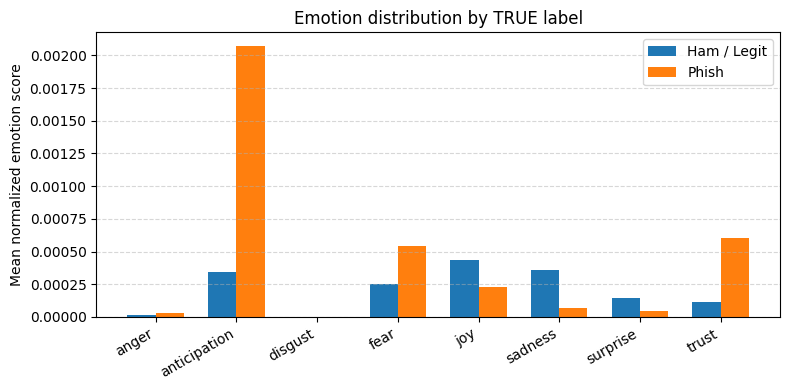

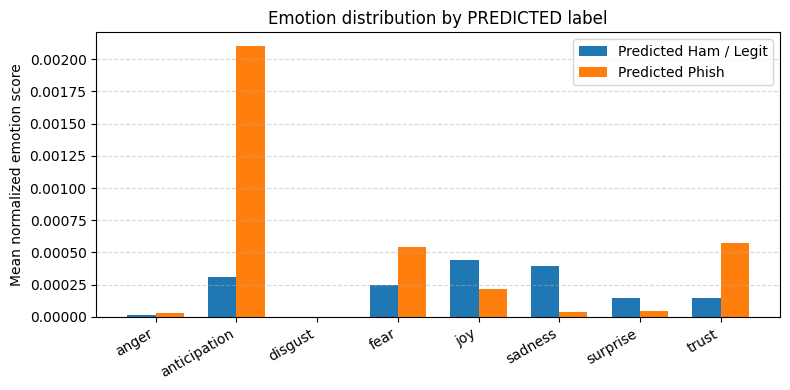

In [ ]:
# ==============================================
# 13) Bar charts for emotion distributions
#     - One figure for TRUE labels (ham vs phish)
#     - One figure for PREDICTED labels (ham vs phish)
# ==============================================
import matplotlib.pyplot as plt
import numpy as np

# Convert dicts to arrays in consistent order (0=ham, 1=phish)
ham_true   = mean_by_true.get(0, np.zeros(len(EMOTIONS), dtype=np.float32))
phish_true = mean_by_true.get(1, np.zeros(len(EMOTIONS), dtype=np.float32))

ham_pred   = mean_by_pred.get(0, np.zeros(len(EMOTIONS), dtype=np.float32))
phish_pred = mean_by_pred.get(1, np.zeros(len(EMOTIONS), dtype=np.float32))

x = np.arange(len(EMOTIONS))
width = 0.35  # width of the bars

# ----------------------------------------------
# Figure 1: Emotions by TRUE label
# ----------------------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 4))

ax1.bar(x - width/2, ham_true,  width, label='Ham / Legit')
ax1.bar(x + width/2, phish_true, width, label='Phish')

ax1.set_ylabel('Mean normalized emotion score')
ax1.set_title('Emotion distribution by TRUE label')
ax1.set_xticks(x)
ax1.set_xticklabels(EMOTIONS, rotation=30, ha='right')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optionally save for report (hi-res PNG)
fig1.savefig('emotions_true_labels.png', dpi=300, bbox_inches='tight')

# ----------------------------------------------
# Figure 2: Emotions by PREDICTED label
# ----------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 4))

ax2.bar(x - width/2, ham_pred,  width, label='Predicted Ham / Legit')
ax2.bar(x + width/2, phish_pred, width, label='Predicted Phish')

ax2.set_ylabel('Mean normalized emotion score')
ax2.set_title('Emotion distribution by PREDICTED label')
ax2.set_xticks(x)
ax2.set_xticklabels(EMOTIONS, rotation=30, ha='right')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optionally save for your report
#fig2.savefig('emotions_pred_labels.png', dpi=300, bbox_inches='tight')


Inference helper (for ad-hoc strings or CSV rows) (optional test)

In [ ]:
# ==============================================
# 10) Inference utility
#     - Accepts raw text; returns predicted class ID
# ==============================================
def predict_text(model, text, max_len=256):
    model.eval()
    with torch.no_grad():
        ids, L = encode(text, max_len=max_len)       # uses the train-built vocab (stoi)
        ids = ids.unsqueeze(0).to(device)            # [1, T]
        L = L.unsqueeze(0).to(device)                # [1]
        logits = model(ids, L)                       # [1, C]
        pred = logits.argmax(dim=1).item()           # int
    return pred

# Example test
example_text = "Urgent: Your account is locked, click here to verify your credentials."
pred = predict_text(model, example_text)
print("Predicted class:", "phish" if pred == 1 else "ham")

Predicted class: phish


Optional per-class stats from CM (macro by hand):

In [ ]:
def per_class_metrics_from_cm(cm):
    # Precision/Recall/F1 per class using counts in CM
    C = cm.shape[0]
    metrics = []
    for cls in range(C):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec  = tp / (tp + fn) if (tp + fn) else 0.0
        f1   = (2*prec*rec / (prec + rec)) if (prec + rec) else 0.0
        metrics.append({"class": cls, "precision": prec, "recall": rec, "f1": f1})
    return metrics

# Example:
stats = per_class_metrics_from_cm(cm)
for s in stats:
    print(s)

{'class': 0, 'precision': np.float64(0.983345507669832), 'recall': np.float64(0.983345507669832), 'f1': np.float64(0.983345507669832)}
{'class': 1, 'precision': np.float64(0.9852312475709288), 'recall': np.float64(0.9852312475709288), 'f1': np.float64(0.9852312475709288)}


Learning-curve plots (loss, accuracy, F1)

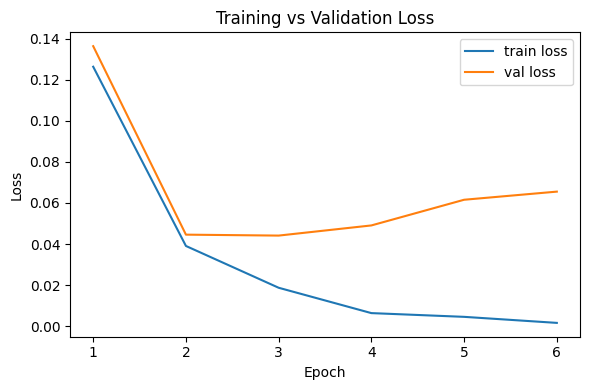

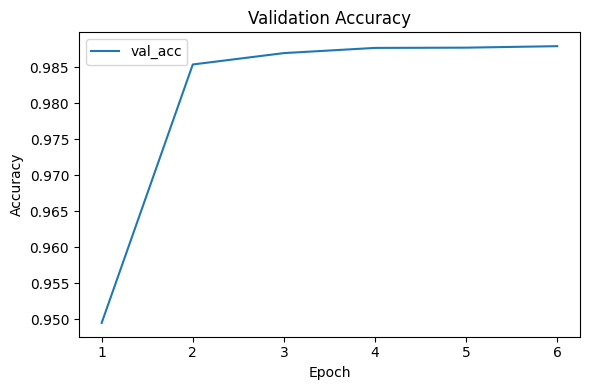

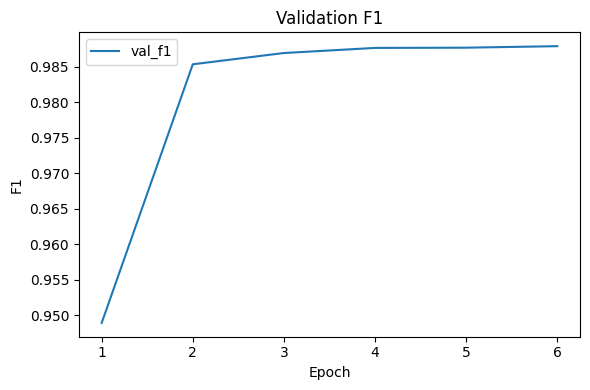

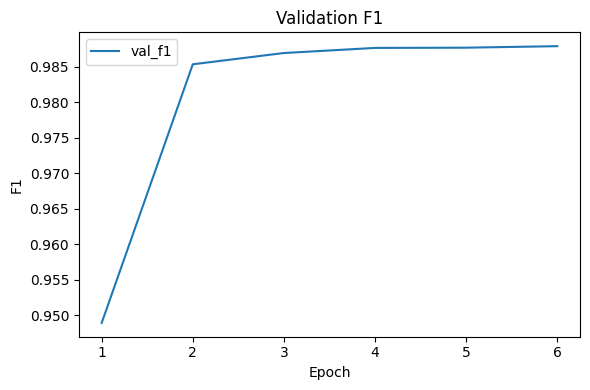

In [ ]:
# ==============================================
# Learning curves: plot loss and metrics vs. epochs
# ==============================================
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(history):
    # Single chart: training loss and validation loss
    fig, ax = plt.subplots(figsize=(6, 4))
    epochs = np.arange(1, len(history["train_loss"]) + 1)
    ax.plot(epochs, history["train_loss"], label="train loss")
    ax.plot(epochs, history["val_loss"],   label="val loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training vs Validation Loss")
    ax.legend()
    fig.tight_layout()
    plt.show()
    return fig

def plot_metric_curve(history, key="val_acc", ylabel="Accuracy", title="Validation Accuracy"):
    # Single chart: one metric (e.g., val_acc or val_f1)
    fig, ax = plt.subplots(figsize=(6, 4))
    epochs = np.arange(1, len(history[key]) + 1)
    ax.plot(epochs, history[key], label=key)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    plt.show()
    return fig

# Example usage after training:
plot_loss_curves(history)
plot_metric_curve(history, key="val_acc", ylabel="Accuracy", title="Validation Accuracy")
plot_metric_curve(history, key="val_f1",  ylabel="F1",       title="Validation F1")
